<a href="https://colab.research.google.com/github/jdlg-42/TFG/blob/main/distancias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install igraph
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.5 MB/s eta 0:00:00


# Descargar .mmCIF para hacer el grafo

Para esta parte del análisis es esencial tener el valor en la secuencia de la proteína. Sin embargo, en los archivos PDB no suele ser común que se almacene las posiciones de esa manera, sino que lo hace en el indexado auth, que se corresponde con el estudio de la estructura tridimensional. Para corregir esto trabajamos con el formato .cif, que si recoge la posición del aminoácido en la secuencia lineal.

In [2]:
# Descargar un archivo .mmCIF desde el RCSB PDB
import os
import requests

def download_mmcif(pdb_id, save_dir="mmcif_files"):
    """
    Descarga el archivo .mmCIF para el PDB ID dado desde el servidor de RCSB.

    Args:
        pdb_id (str): Identificador de la proteína en el PDB (e.g., "2YDO").
        save_dir (str): Carpeta donde se guardará el archivo.

    Returns:
        str: Ruta al archivo descargado.
    """
    pdb_id = pdb_id.lower()
    url = f"https://files.rcsb.org/download/{pdb_id}.cif"

    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, f"{pdb_id}.cif")

    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, "w") as f:
            f.write(response.text)
        print(f"✅ Archivo descargado: {file_path}")
        return file_path
    else:
        raise ValueError(f"No se pudo descargar el archivo para PDB ID '{pdb_id}'. Código de estado: {response.status_code}")


Estas son las cuatro estructuras con las que trabajamos. Con este bloque se descargan sus respectivos archivos en formato .cif

In [3]:
pdbs = ["2YDO", "5G53", "2R4R", "3SN6"]
for pdb in pdbs:
  download_mmcif(pdb)

✅ Archivo descargado: mmcif_files/2ydo.cif
✅ Archivo descargado: mmcif_files/5g53.cif
✅ Archivo descargado: mmcif_files/2r4r.cif
✅ Archivo descargado: mmcif_files/3sn6.cif


# PSN de atención

Para receptor A2A de adenosina:

* 2YDO: cadena A, sites["A2A_adenosine"], sites["A2A_G"]
* 5G53: cadena A, sites["A2A_adenosine"], sites["A2A_G"]

Para receptor beta-2 adrenérgico:
* 4LDO: cadena A, sites["beta2AR_epi4ldo"], sites["beta2AR_G_4ldo"]
* 3SN6: cadena R, sites["beta2AR_epi3sn6"], sites["beta2AR_G_3sn6"]

In [4]:
# Diccionario de sitios importantes

sites = {
    "A2A_adenosine": [168, 169, 253, 277, 278],
    "A2A_G": [102, 110, 227, 231, 235],
    "beta2AR_epi": [113, 203, 204, 207, 293, 296, 308, 312],
    "beta2AR_G":[68, 130, 131, 139, 141],
    }

## PSN de 2YDO

<ipython-input-5-ea733fbb513e>:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")



Nodos con atención y betweenness por encima del percentil 80:
  Asn280 | Atención: 0.56280 | Betweenness: 1406.53
  His278 | Atención: 0.36367 | Betweenness: 2262.34
  Ser281 | Atención: 0.33866 | Betweenness: 1601.91
  His250 | Atención: 0.22742 | Betweenness: 1357.82
  Pro285 | Atención: 0.19205 | Betweenness: 2055.48
  Val282 | Atención: 0.11017 | Betweenness: 2561.98
  Asp170 | Atención: 0.07915 | Betweenness: 1420.64
  Val172 | Atención: 0.07077 | Betweenness: 2289.33
  Pro173 | Atención: 0.06816 | Betweenness: 1179.88
  Arg296 | Atención: 0.04184 | Betweenness: 1257.81
  Glu312 | Atención: 0.03106 | Betweenness: 1970.76
  Met174 | Atención: 0.02935 | Betweenness: 1224.63
  Phe299 | Atención: 0.02692 | Betweenness: 2835.96
  Met177 | Atención: 0.02604 | Betweenness: 1988.57
  Asn284 | Atención: 0.02311 | Betweenness: 2063.31


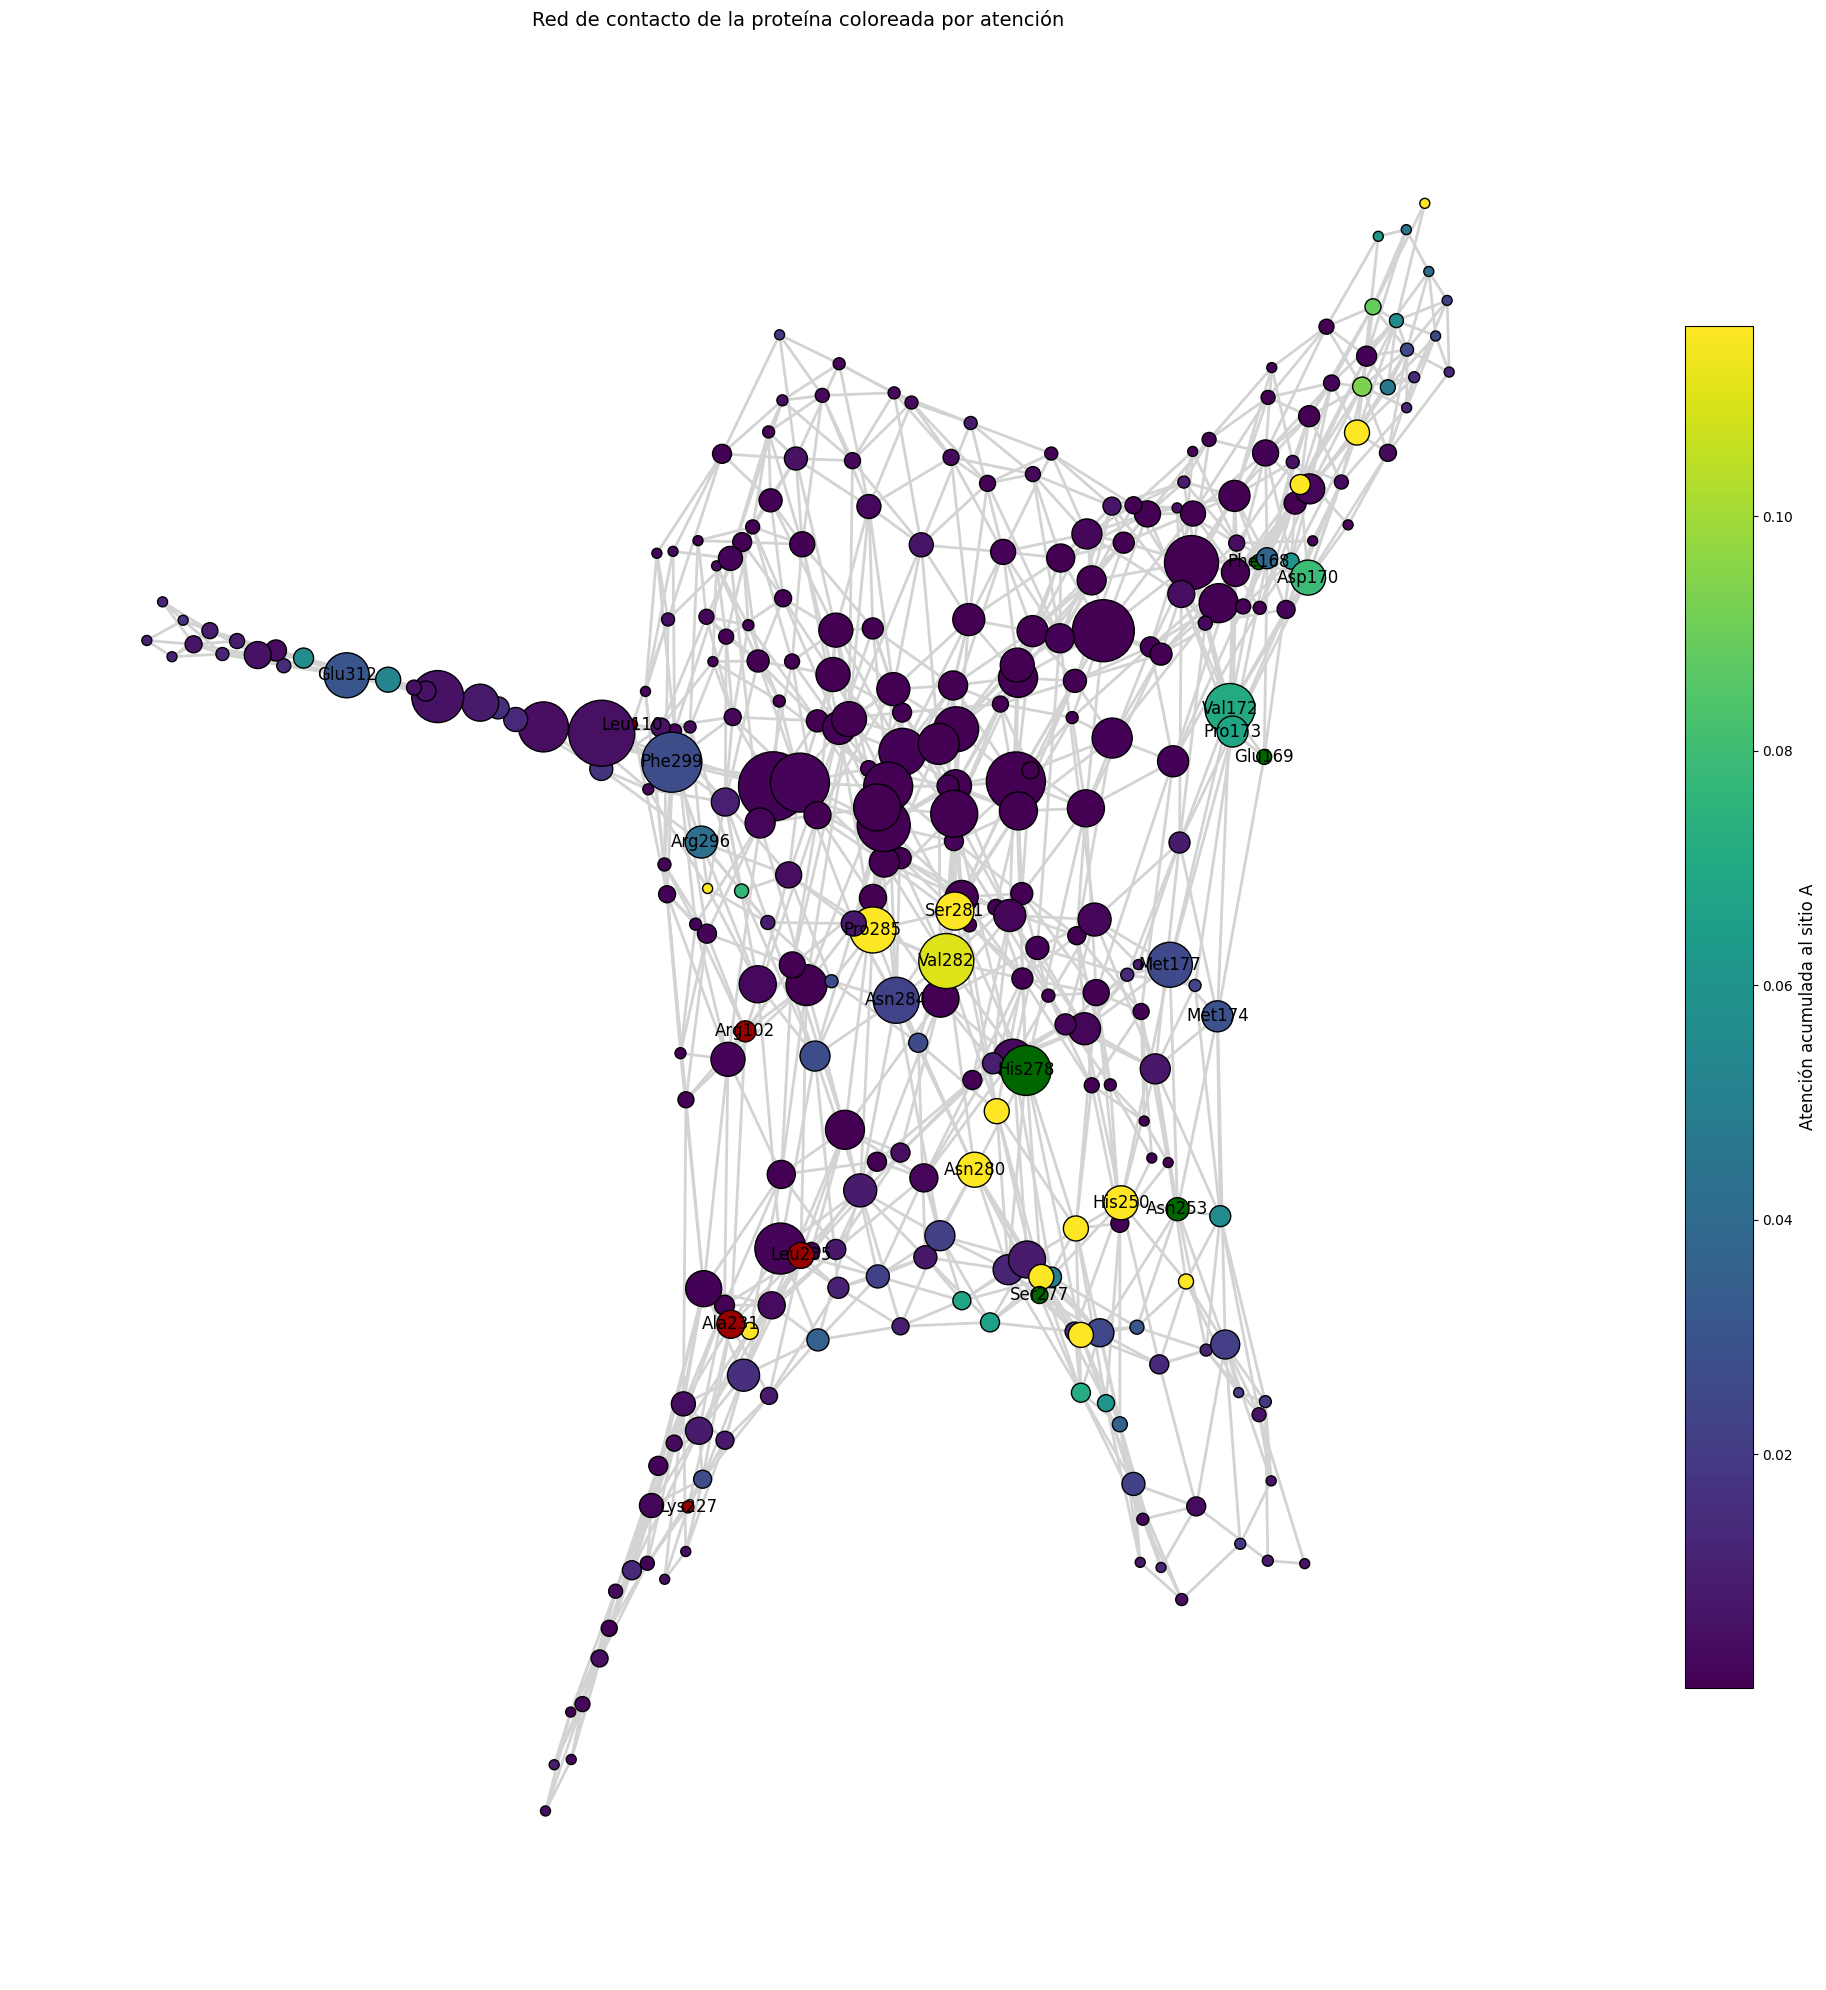

In [5]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict

# Configuraciones iniciales
pdb_id = "2YDO"
chain_id = "A"
cif_path = f"/content/mmcif_files/{pdb_id.lower()}.cif"
csv_path = "attention_to_allosteric_sites_a2a.csv"

# Define tus sitios de interés (debes definir el dict 'sites' antes de ejecutar esto)
sitio_A = sites["A2A_adenosine"]
sitio_O = sites["A2A_G"]

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con resname ===
CA_coord = []
CA_info = []
resnum_to_resname = {}

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue and residue.id[0] == " ":
                    label_seq_id = residue.get_id()[1]
                    coord = residue["CA"].get_coord()
                    resname = residue.get_resname().capitalize()
                    resnum = residue.get_id()[1]
                    resnum_to_resname[resnum] = resname
                    CA_coord.append(coord)
                    CA_info.append((chain.id, label_seq_id, "", resname))


# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid[:3]: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}


g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    10 + 60 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Agrupación de atención por pares From-To (promediando entre cabezas)
pair_attention = defaultdict(list)

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = row["Attention Score"]
    pair_attention[(from_pos, to_pos)].append(score)

# Atención acumulada a sitio A por nodo "From"
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for (from_pos, to_pos), scores in pair_attention.items():
    avg_score = sum(scores) / len(scores)
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += avg_score

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")

g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)

# === Calcular el percentil para betweenness y atención ===
percentile = 80
percentil_btw = np.percentile(g.vs["betweenness"], percentile)
percentil_att = np.percentile(att_values, percentile)

# Extraer nodos que cumplen ambas condiciones
nodos_destacados = []
for i, node in enumerate(g.vs):
    att = attention_scores.get(i, 0.0)
    btw = node["betweenness"]
    if att > percentil_att and btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "attention": att,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta

# Ordenar nodos por atención y betweenness (desc)
nodos_ordenados = sorted(nodos_destacados, key=lambda x: (x["attention"], x["betweenness"]), reverse=True)

# Imprimir resultados
print(f"\nNodos con atención y betweenness por encima del percentil {percentile}:")
print("=" * 60)
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Atención: {nodo['attention']:.5f} | Betweenness: {nodo['betweenness']:.2f}")


# === Dibujo del grafo ===
layout = g.layout_fruchterman_reingold()
fig, ax = plt.subplots(figsize=(20, 20))

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    bbox=(1000, 1000),
    margin=20,
)

# Barra de color
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)

plt.title("Red de contacto de la proteína coloreada por atención", fontsize=14)
plt.tight_layout()
plt.show()


## PSN de 5G53

<ipython-input-6-310af54ccd24>:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")



Nodos con atención y betweenness por encima del percentil 80:
  Asn280 | Atención: 0.56280 | Betweenness: 2278.61
  His278 | Atención: 0.36367 | Betweenness: 2797.52
  Ser281 | Atención: 0.33866 | Betweenness: 1411.00
  Pro285 | Atención: 0.19205 | Betweenness: 1085.78
  Val282 | Atención: 0.11017 | Betweenness: 1512.16
  Val172 | Atención: 0.07077 | Betweenness: 1524.34
  Arg296 | Atención: 0.04184 | Betweenness: 1206.70
  Met174 | Atención: 0.02935 | Betweenness: 1162.36
  Phe299 | Atención: 0.02692 | Betweenness: 1196.54
  Ile287 | Atención: 0.02606 | Betweenness: 1670.25
  Leu249 | Atención: 0.02472 | Betweenness: 1048.79
  Asn284 | Atención: 0.02311 | Betweenness: 1362.07
  Phe242 | Atención: 0.02267 | Betweenness: 1140.56
  Val239 | Atención: 0.02195 | Betweenness: 2039.32


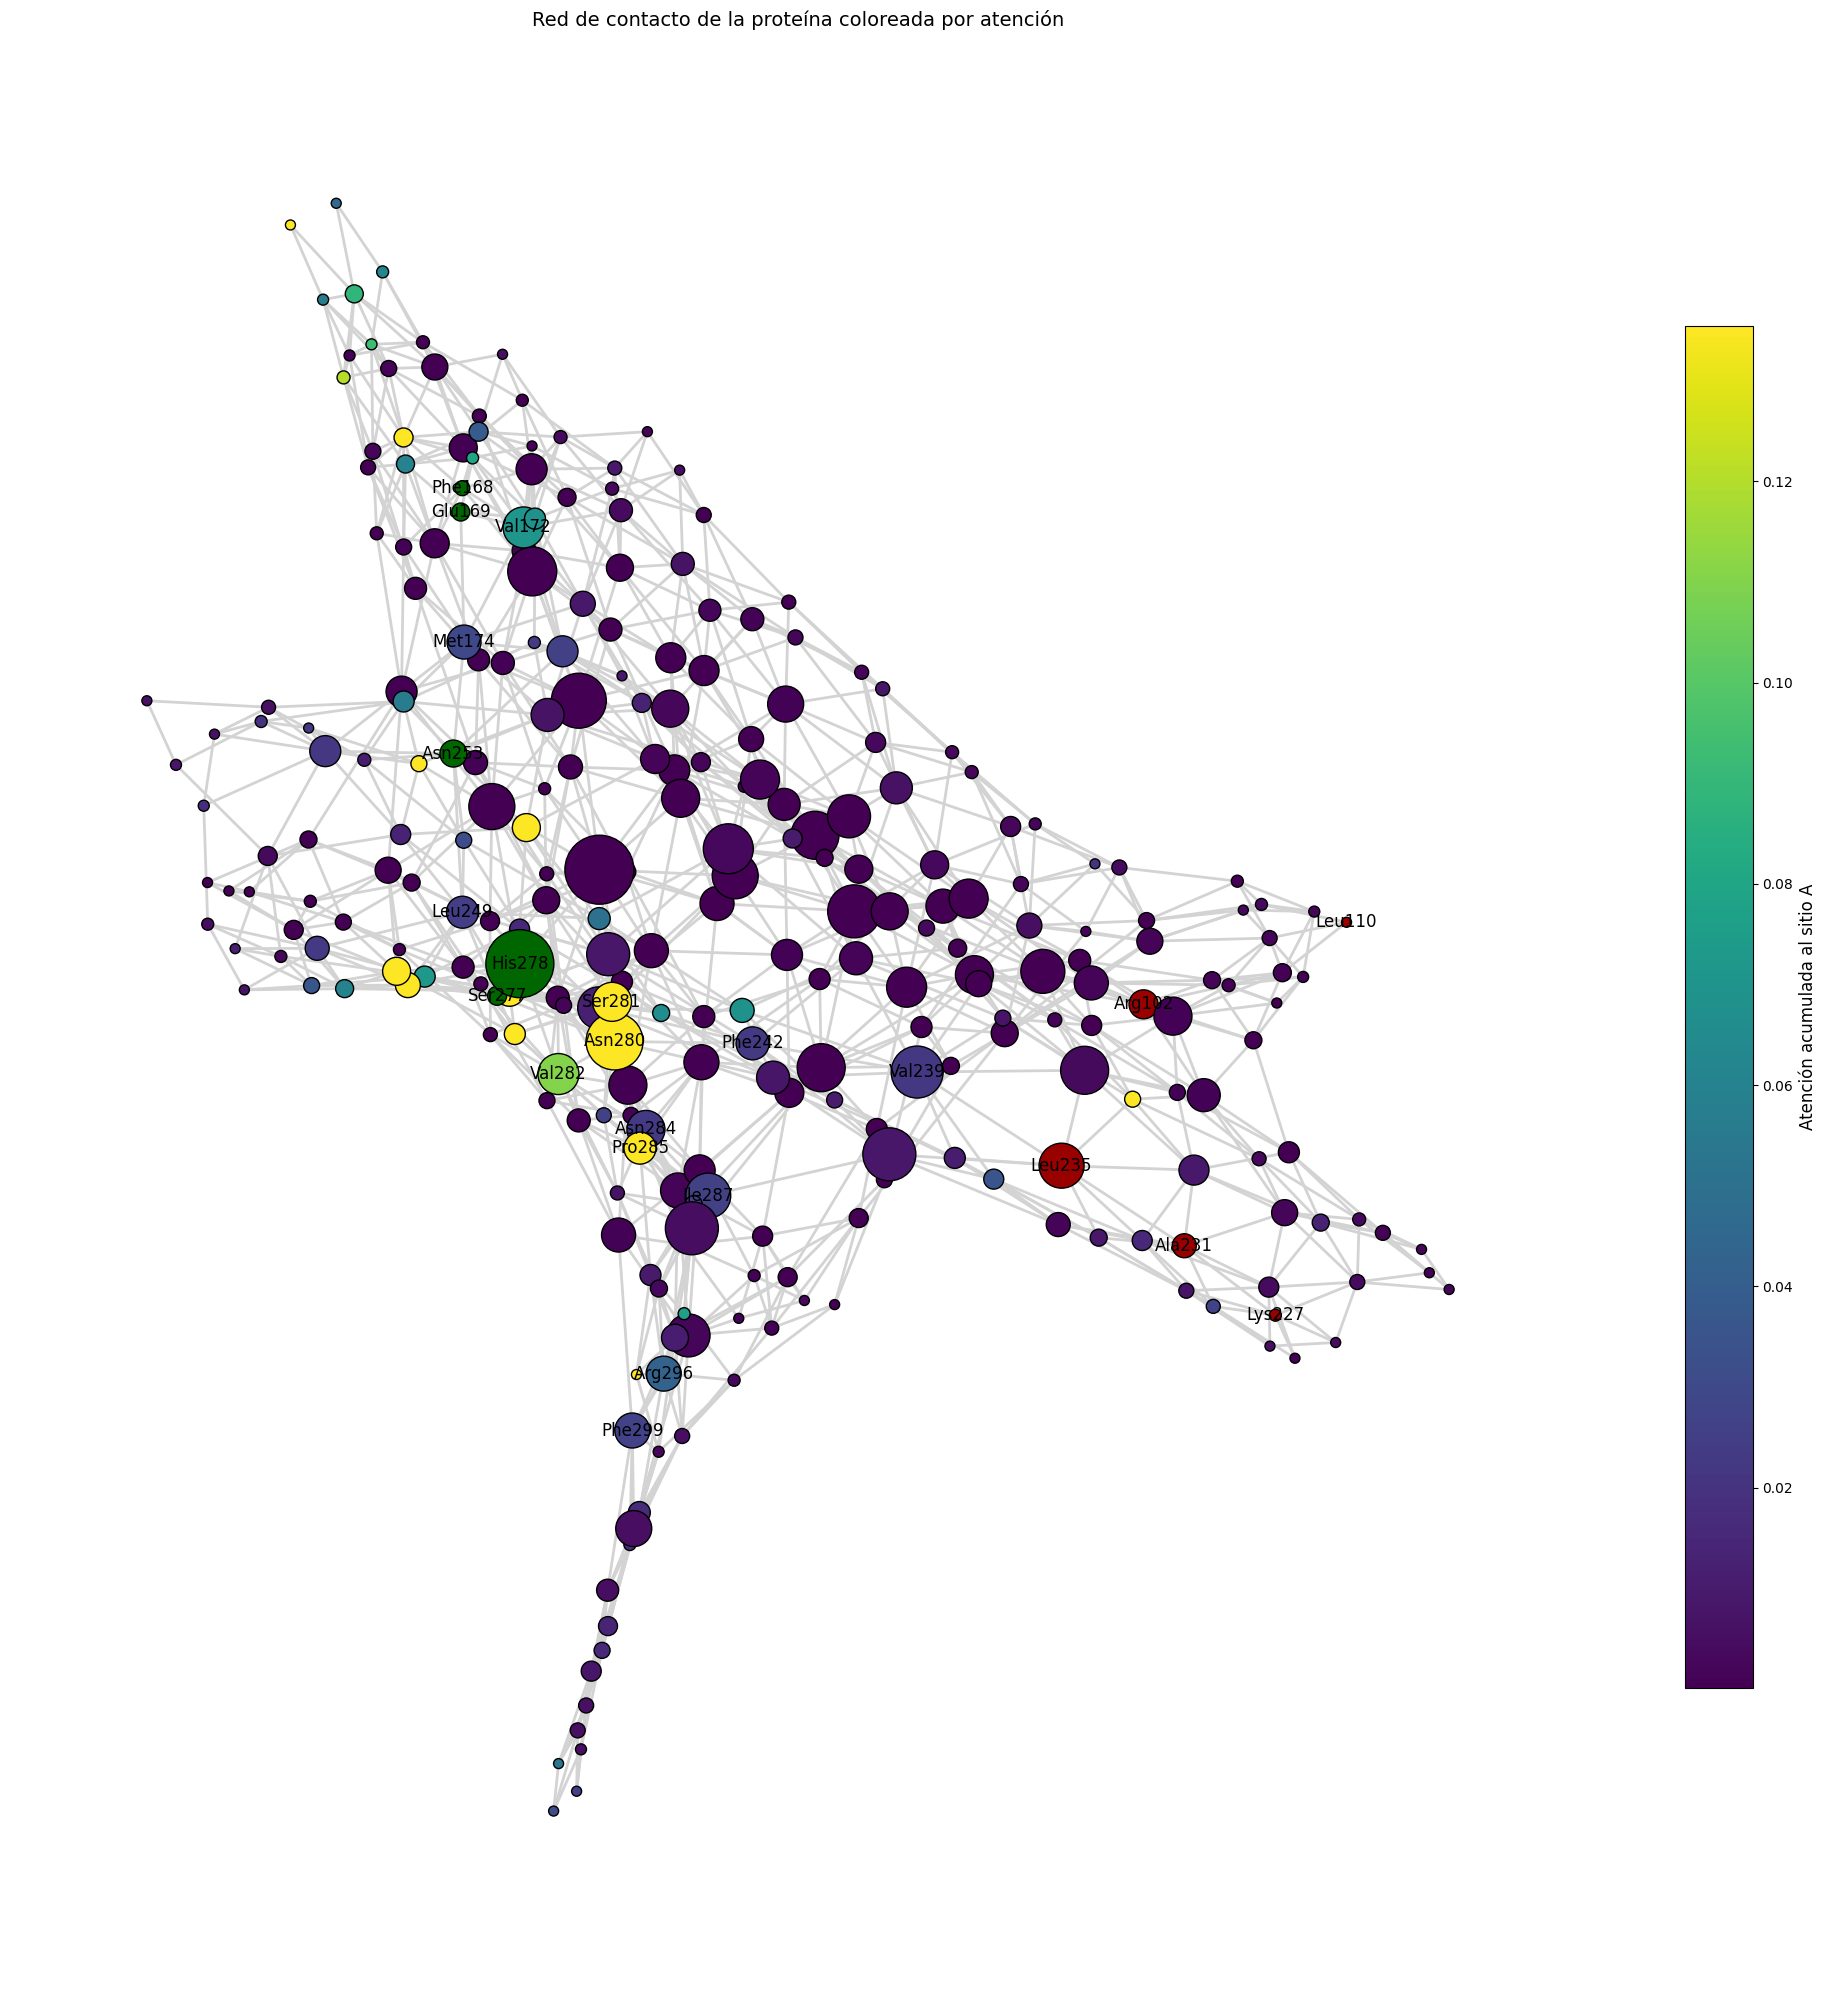

In [6]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict

# Configuraciones iniciales
pdb_id = "5G53"
chain_id = "A"
cif_path = f"/content/mmcif_files/{pdb_id.lower()}.cif"
csv_path = "attention_to_allosteric_sites_a2a.csv"

# Define tus sitios de interés (debes definir el dict 'sites' antes de ejecutar esto)
sitio_A = sites["A2A_adenosine"]
sitio_O = sites["A2A_G"]

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con resname ===
CA_coord = []
CA_info = []
resnum_to_resname = {}

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue and residue.id[0] == " ":
                    label_seq_id = residue.get_id()[1]
                    coord = residue["CA"].get_coord()
                    resname = residue.get_resname().capitalize()
                    resnum = residue.get_id()[1]
                    resnum_to_resname[resnum] = resname
                    CA_coord.append(coord)
                    CA_info.append((chain.id, label_seq_id, "", resname))


# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid[:3]: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}


g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    10 + 60 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Agrupación de atención por pares From-To (promediando entre cabezas)
pair_attention = defaultdict(list)

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = row["Attention Score"]
    pair_attention[(from_pos, to_pos)].append(score)

# Atención acumulada a sitio A por nodo "From"
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for (from_pos, to_pos), scores in pair_attention.items():
    avg_score = sum(scores) / len(scores)
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += avg_score

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")


g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)

# === Calcular el percentil para betweenness y atención ===
percentile = 80
percentil_btw = np.percentile(g.vs["betweenness"], percentile)
percentil_att = np.percentile(att_values, percentile)

# Extraer nodos que cumplen ambas condiciones
nodos_destacados = []
for i, node in enumerate(g.vs):
    att = attention_scores.get(i, 0.0)
    btw = node["betweenness"]
    if att > percentil_att and btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "attention": att,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta

# Ordenar nodos por atención y betweenness (desc)
nodos_ordenados = sorted(nodos_destacados, key=lambda x: (x["attention"], x["betweenness"]), reverse=True)

# Imprimir resultados
print(f"\nNodos con atención y betweenness por encima del percentil {percentile}:")
print("=" * 60)
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Atención: {nodo['attention']:.5f} | Betweenness: {nodo['betweenness']:.2f}")


# === Dibujo del grafo ===
layout = g.layout_fruchterman_reingold()
fig, ax = plt.subplots(figsize=(20, 20))

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    bbox=(1000, 1000),
    margin=20,
)

# Barra de color
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)

plt.title("Red de contacto de la proteína coloreada por atención", fontsize=14)
plt.tight_layout()
plt.show()


## PSN de 2R4R

Filas en df_att después de filtrar sitio_A (8 residuos): 53120

Nodos con atención y betweenness por encima del percentil 80:
  Leu124 | Atención: 0.10939 | Betweenness: 1564.52
  Pro323 | Atención: 0.09240 | Betweenness: 1149.32
  Thr123 | Atención: 0.07365 | Betweenness: 1482.31
  Ala226 | Atención: 0.05698 | Betweenness: 1051.29
  Ile121 | Atención: 0.05385 | Betweenness: 2256.35
  Asn318 | Atención: 0.05157 | Betweenness: 798.63
  Ser329 | Atención: 0.04795 | Betweenness: 850.33


<ipython-input-7-7200bd915203>:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


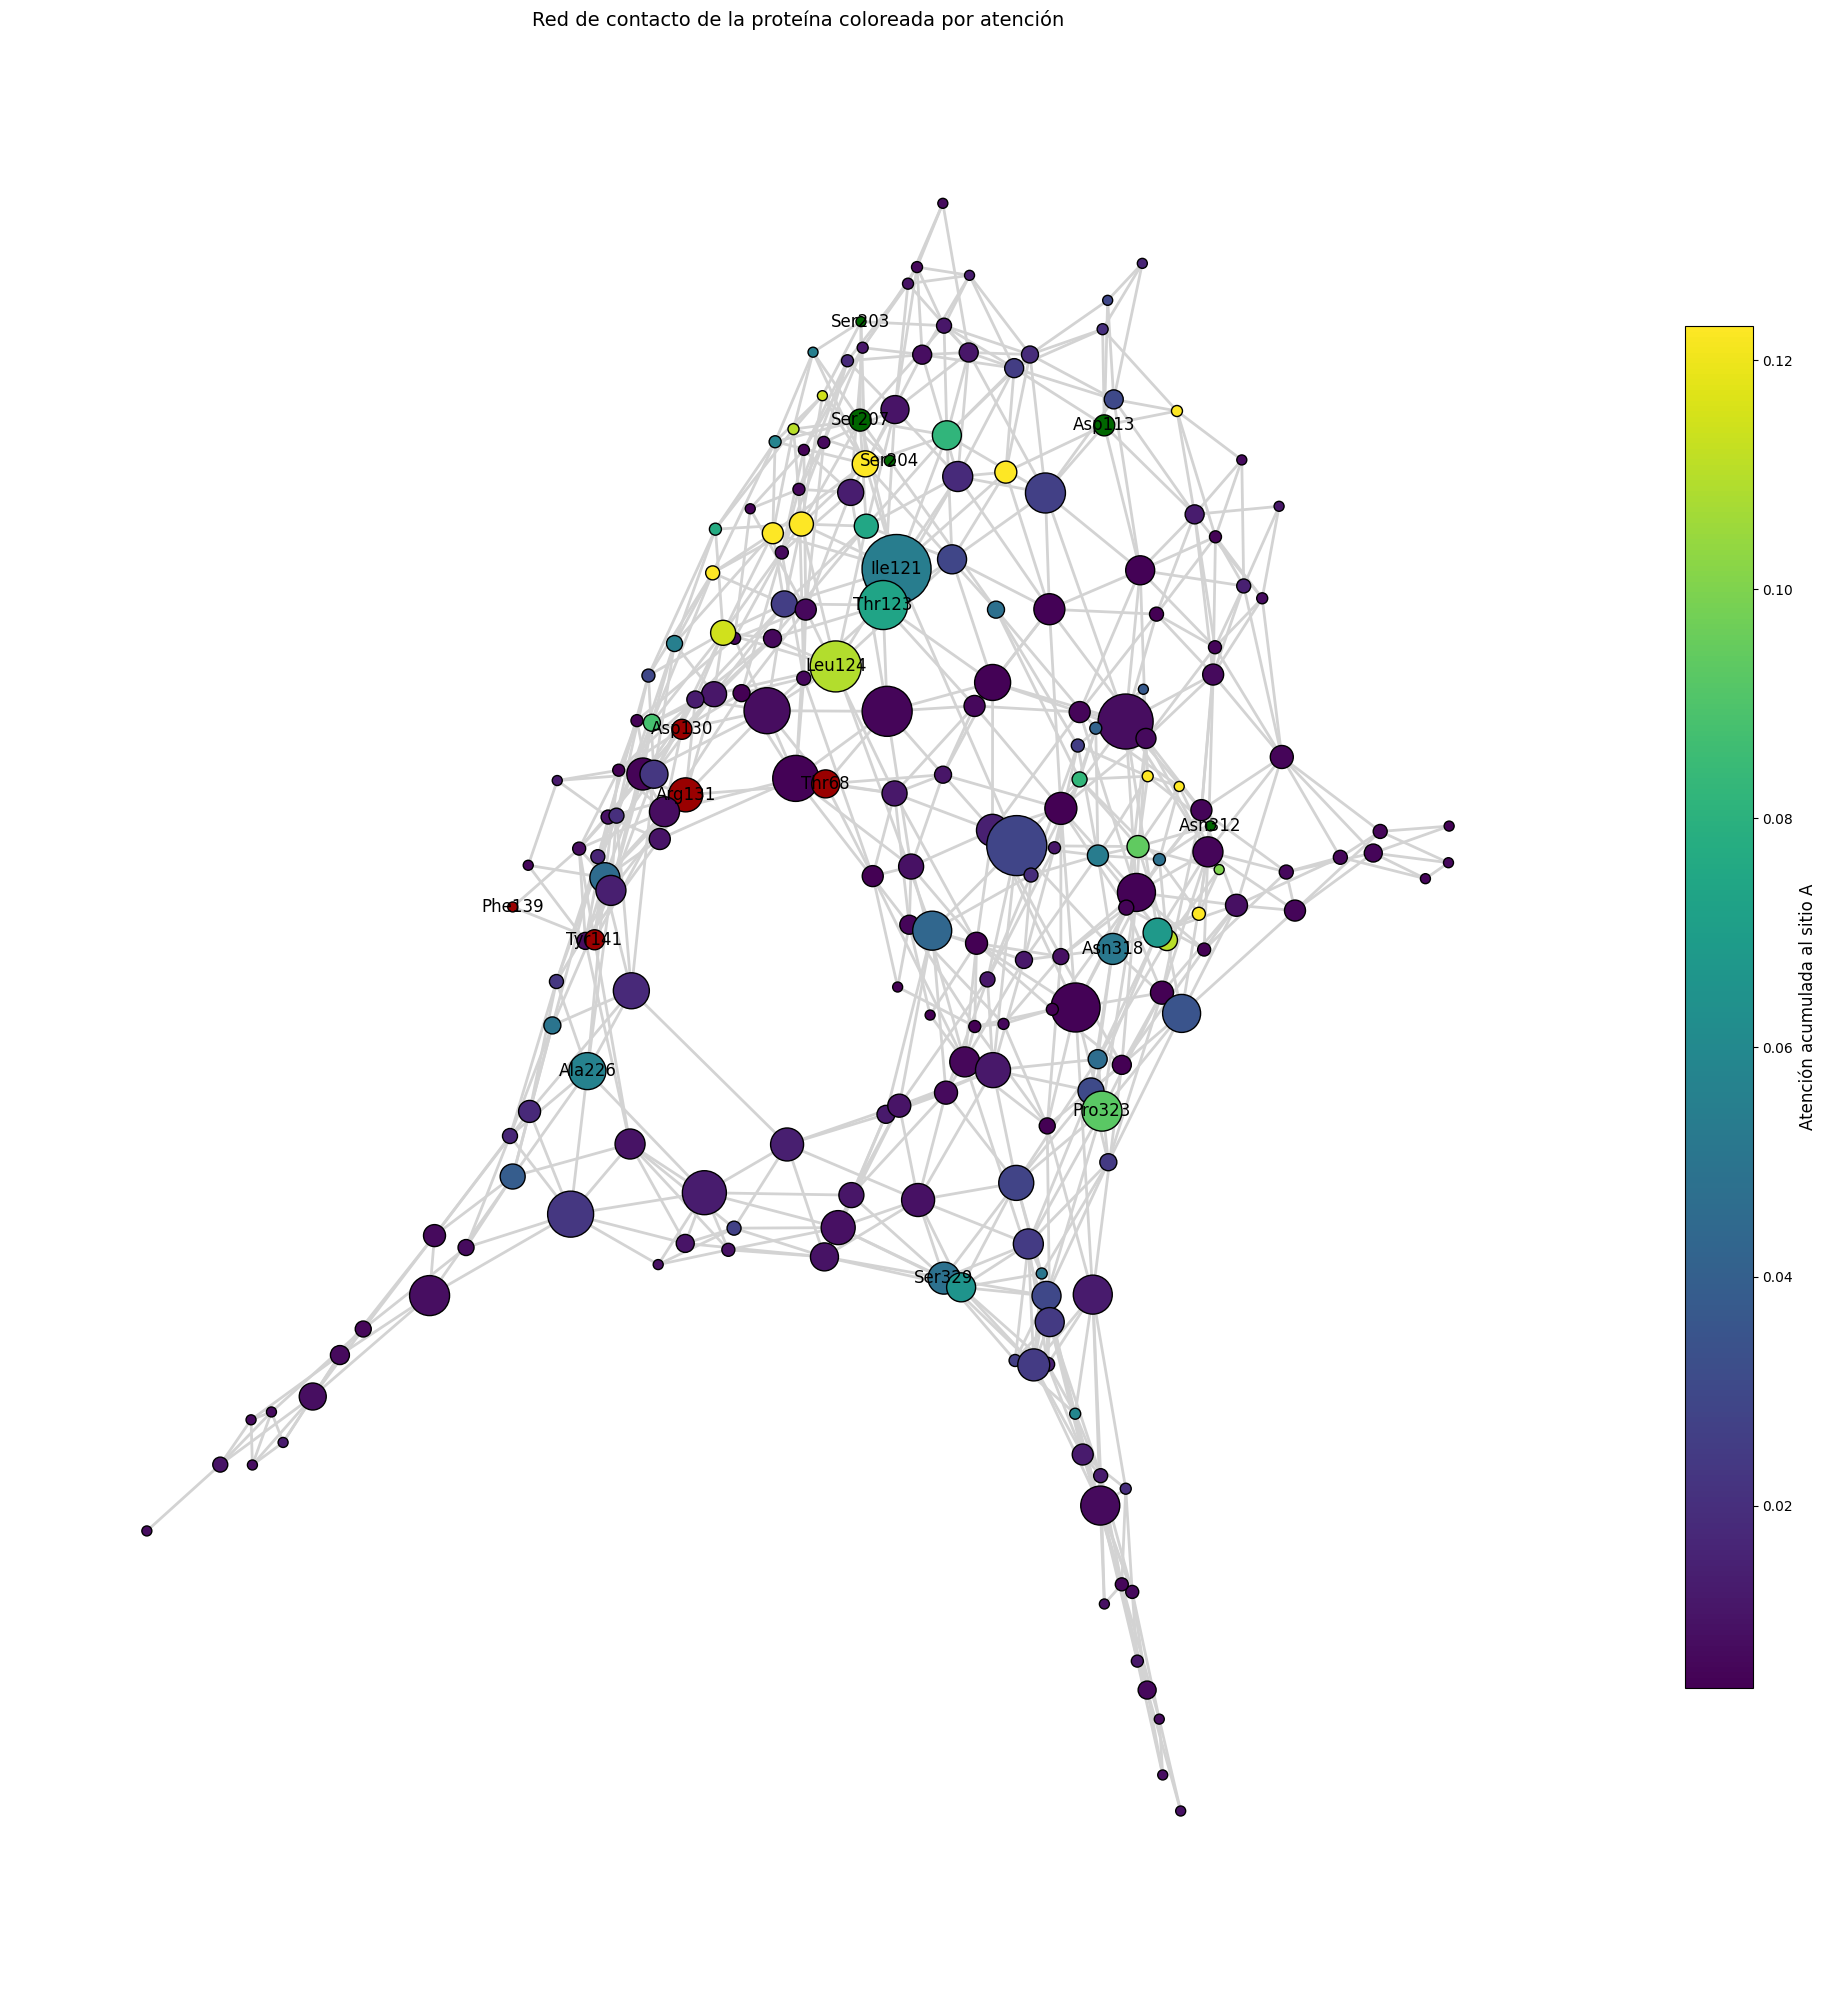

In [7]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict

# Configuraciones iniciales
pdb_id = "2R4R"
chain_id = "A"
cif_path = f"/content/mmcif_files/{pdb_id.lower()}.cif"
csv_path = "attention_to_allosteric_sites_adrb2.csv"

# Define tus sitios de interés (debes definir el dict 'sites' antes de ejecutar esto)
sitio_A = sites["beta2AR_epi"]
sitio_O = sites["beta2AR_G"]

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con resname ===
CA_coord = []
CA_info = []
resnum_to_resname = {}

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue and residue.id[0] == " ":
                    label_seq_id = residue.get_id()[1]
                    coord = residue["CA"].get_coord()
                    resname = residue.get_resname().capitalize()
                    resnum = residue.get_id()[1]
                    resnum_to_resname[resnum] = resname
                    CA_coord.append(coord)
                    CA_info.append((chain.id, label_seq_id, "", resname))


# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid[:3]: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}


g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    10 + 60 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Agrupación de atención por pares From-To (promediando entre cabezas)
pair_attention = defaultdict(list)

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = row["Attention Score"]
    pair_attention[(from_pos, to_pos)].append(score)

# Atención acumulada a sitio A por nodo "From"
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for (from_pos, to_pos), scores in pair_attention.items():
    avg_score = sum(scores) / len(scores)
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += avg_score
print(f"Filas en df_att después de filtrar sitio_A ({len(sitio_A)} residuos): {len(df_att)}")
if len(df_att) == 0:
    print("Advertencia: No hay datos de atención para el sitio alostérico.")

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")


g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)

# === Calcular el percentil para betweenness y atención ===
percentile = 80
percentil_btw = np.percentile(g.vs["betweenness"], percentile)
percentil_att = np.percentile(att_values, percentile)

# Extraer nodos que cumplen ambas condiciones
nodos_destacados = []
for i, node in enumerate(g.vs):
    att = attention_scores.get(i, 0.0)
    btw = node["betweenness"]
    if att > percentil_att and btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "attention": att,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta

# Ordenar nodos por atención y betweenness (desc)
nodos_ordenados = sorted(nodos_destacados, key=lambda x: (x["attention"], x["betweenness"]), reverse=True)

# Imprimir resultados
print(f"\nNodos con atención y betweenness por encima del percentil {percentile}:")
print("=" * 60)
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Atención: {nodo['attention']:.5f} | Betweenness: {nodo['betweenness']:.2f}")


# === Dibujo del grafo ===
layout = g.layout_fruchterman_reingold()
fig, ax = plt.subplots(figsize=(20, 20))

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    bbox=(1000, 1000),
    margin=20,
)

# Barra de color
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)

plt.title("Red de contacto de la proteína coloreada por atención", fontsize=14)
plt.tight_layout()
plt.show()


## PSN de 3SN6

In [13]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict

# Configuraciones iniciales
pdb_id = "3SN6"
chain_id = "R"
cif_path = f"/content/mmcif_files/{pdb_id.lower()}.cif"
csv_path = "attention_to_allosteric_sites_adrb2.csv"

# Define tus sitios de interés (debes definir el dict 'sites' antes de ejecutar esto)
sitio_A = sites["beta2AR_epi"]
sitio_O = sites["beta2AR_G"]

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con resname ===
CA_coord = []
CA_info = []
resnum_to_resname = {}

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                # Saltar residuos no estándar o con ID <= 161
                if "CA" not in residue or residue.id[0] != " ":
                    continue
                resnum = residue.get_id()[1]
                if resnum <= 161:
                    continue  # Excluir lisozima de fusión

                coord = residue["CA"].get_coord()
                resname = residue.get_resname().capitalize()
                resnum_to_resname[resnum] = resname
                CA_coord.append(coord)
                CA_info.append((chain.id, resnum, "", resname))


# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid[:3]: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}


g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    10 + 60 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Agrupación de atención por pares From-To (promediando entre cabezas)
pair_attention = defaultdict(list)

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = row["Attention Score"]
    pair_attention[(from_pos, to_pos)].append(score)

# Atención acumulada a sitio A por nodo "From"
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for (from_pos, to_pos), scores in pair_attention.items():
    avg_score = sum(scores) / len(scores)
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += avg_score

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")


g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)

# === Calcular el percentil para betweenness y atención ===
percentile = 80
percentil_btw = np.percentile(g.vs["betweenness"], percentile)
percentil_att = np.percentile(att_values, percentile)

# Extraer nodos que cumplen ambas condiciones
nodos_destacados = []
for i, node in enumerate(g.vs):
    att = attention_scores.get(i, 0.0)
    btw = node["betweenness"]
    if att > percentil_att and btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "attention": att,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta

# Ordenar nodos por atención y betweenness (desc)
nodos_ordenados = sorted(nodos_destacados, key=lambda x: (x["attention"], x["betweenness"]), reverse=True)

# Imprimir resultados
print(f"\nNodos con atención y betweenness por encima del percentil {percentile}:")
print("=" * 60)
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Atención: {nodo['attention']:.5f} | Betweenness: {nodo['betweenness']:.2f}")
print("\nDetalle de contribuciones de atención por nodo:")


# === Dibujo del grafo ===
layout = g.layout_fruchterman_reingold()
fig, ax = plt.subplots(figsize=(20, 20))

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    bbox=(1000, 1000),
    margin=20,
)

# Barra de color
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)

plt.title("Red de contacto de la proteína coloreada por atención", fontsize=14)
plt.tight_layout()
plt.show()


<ipython-input-13-329aab64d0da>:74: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = g.clusters()
<ipython-input-13-329aab64d0da>:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")


IndexError: vertex index out of range

In [ ]:
# Definir `residue_names` basado en la estructura de la proteína
residue_names = []
for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:  # Asegurarnos de que es un carbono alfa
                    residue_names.append(residue.get_resname())  # 'ALA', 'GLY', etc.

# Crear diccionario de residuos con nombre de 3 letras y número
residue_id_map = {
    idx: {"resnum": info[1], "resname": residue_names[idx]}
    for idx, info in enumerate(CA_info)
}

# === Calcular atención acumulada y por TO ===
detailed_attention = {}

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = float(row["Attention Score"])

    if from_pos not in detailed_attention:
        detailed_attention[from_pos] = {}

    if to_pos not in detailed_attention[from_pos]:
        detailed_attention[from_pos][to_pos] = 0.0

    detailed_attention[from_pos][to_pos] += score

# Sumar atención total por residuo
total_attention_per_residue = {
    from_pos: sum(to_scores.values())
    for from_pos, to_scores in detailed_attention.items()
}

# Ordenar residuos por atención total
sorted_residues = sorted(total_attention_per_residue.items(), key=lambda x: x[1], reverse=True)

# Calcular percentil 90
att_values_array = np.array(list(total_attention_per_residue.values()))
threshold = np.percentile(att_values_array, 90)

# === Imprimir resultados ===
print(f"Aminoácidos con atención acumulada superior al percentil 90 ({threshold:.6f}):\n")

for from_pos, total_score in sorted_residues:
    if total_score >= threshold:
        res_data = residue_id_map.get(from_pos, {"resnum": from_pos, "resname": "UNK"})
        print(f"Residuo: {res_data['resname']} {res_data['resnum']} (índice: {from_pos})")
        print(f"  Atención total al sitio A: {total_score:.6f}")
        for to_pos in sitio_A:
            score = detailed_attention[from_pos].get(to_pos, 0.0)
            print(f"    → A{to_pos}: {score:.6f}")
        print("-" * 40)


Aminoácidos con atención acumulada superior al percentil 90 (0.040918):

Residuo: ARG 296 (índice: 280)
  Atención total al sitio A: 0.562803
    → A168: 0.000002
    → A169: 0.000003
    → A253: 0.000079
    → A277: 0.016089
    → A278: 0.546631
----------------------------------------
Residuo: PHE 295 (índice: 279)
  Atención total al sitio A: 0.557517
    → A168: 0.000001
    → A169: 0.000001
    → A253: 0.000034
    → A277: 0.000918
    → A278: 0.556563
----------------------------------------
Residuo: TYR 290 (índice: 274)
  Atención total al sitio A: 0.476749
    → A168: 0.000020
    → A169: 0.000022
    → A253: 0.000381
    → A277: 0.033610
    → A278: 0.442716
----------------------------------------
Residuo: ARG 293 (índice: 277)
  Atención total al sitio A: 0.383612
    → A168: 0.000004
    → A169: 0.000037
    → A253: 0.000121
    → A277: 0.038109
    → A278: 0.345341
----------------------------------------
Residuo: ARG 309 (índice: 293)
  Atención total al sitio A: 0.37364

# Código para generar grafos de PSN

Desde aqui
[('R', 30, ''), ('R', 31, ''), ('R', 32, ''), ('R', 33, ''), ('R', 34, ''), ('R', 35, ''), ('R', 36, ''), ('R', 37, ''), ('R', 38, ''), ('R', 39, ''), ('R', 40, ''), ('R', 41, ''), ('R', 42, ''), ('R', 43, ''), ('R', 44, ''), ('R', 45, ''), ('R', 46, ''), ('R', 47, ''), ('R', 48, ''), ('R', 49, ''), ('R', 50, ''), ('R', 51, ''), ('R', 52, ''), ('R', 53, ''), ('R', 54, ''), ('R', 55, ''), ('R', 56, ''), ('R', 57, ''), ('R', 58, ''), ('R', 59, ''), ('R', 60, ''), ('R', 61, ''), ('R', 62, ''), ('R', 63, ''), ('R', 64, ''), ('R', 65, ''), ('R', 66, ''), ('R', 67, ''), ('R', 68, ''), ('R', 69, ''), ('R', 70, ''), ('R', 71, ''), ('R', 72, ''), ('R', 73, ''), ('R', 74, ''), ('R', 75, ''), ('R', 76, ''), ('R', 77, ''), ('R', 78, ''), ('R', 79, ''), ('R', 80, ''), ('R', 81, ''), ('R', 82, ''), ('R', 83, ''), ('R', 84, ''), ('R', 85, ''), ('R', 86, ''), ('R', 87, ''), ('R', 88, ''), ('R', 89, ''), ('R', 90, ''), ('R', 91, ''), ('R', 92, ''), ('R', 93, ''), ('R', 94, ''), ('R', 95, '')

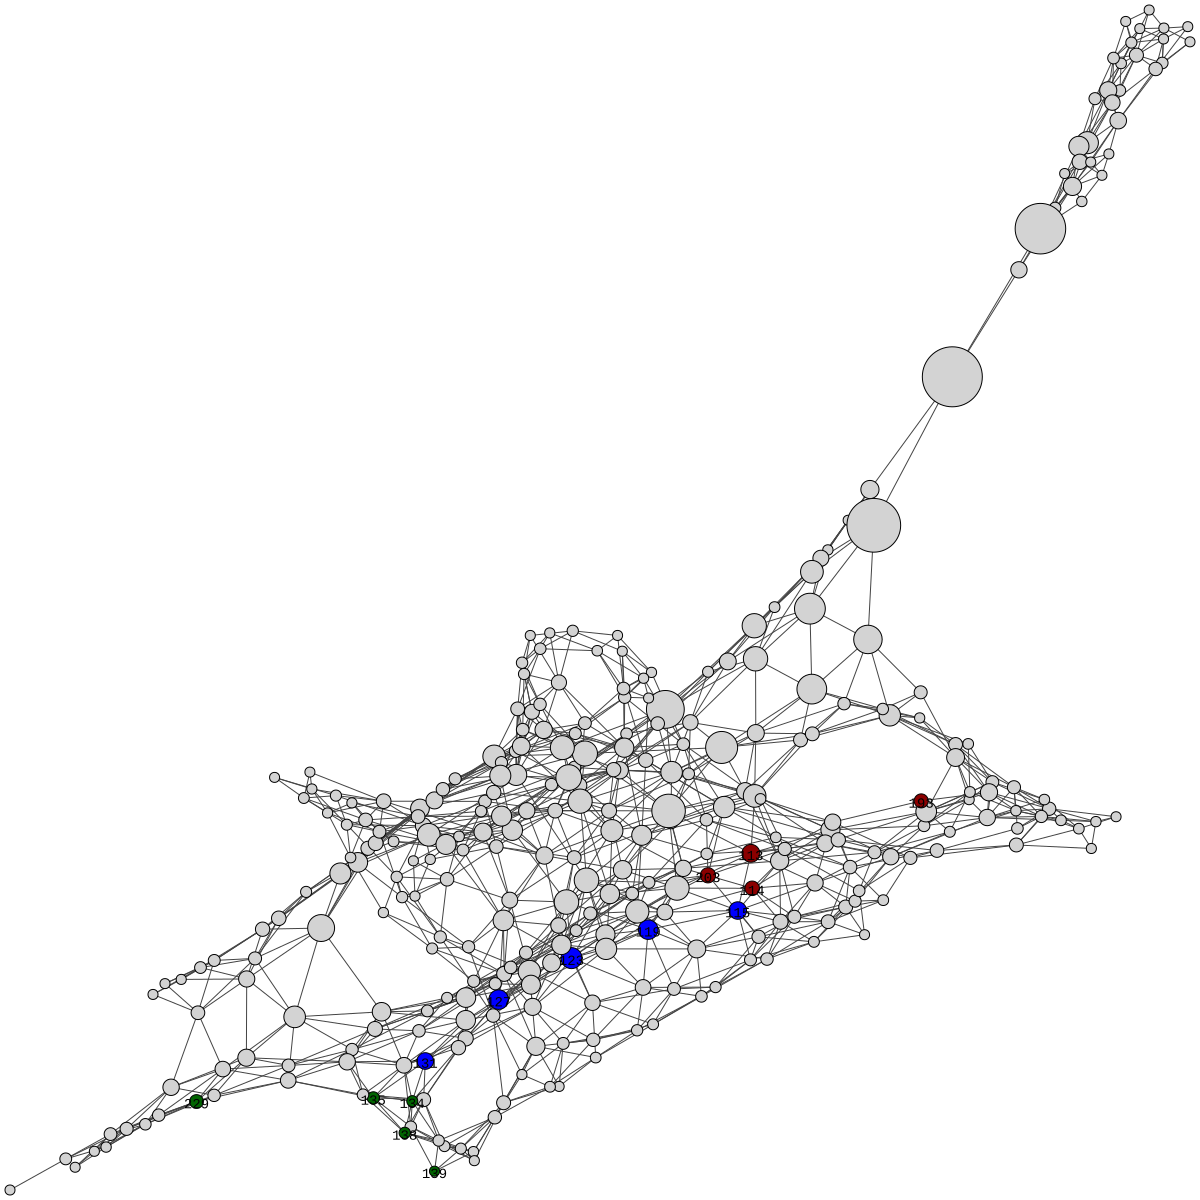

In [ ]:
## Grafo de contacto de proteínas ##

# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

# Configuración de secuencia y

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}_filt.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_info = []  # lista de tuplas: [(chain_id, resnum, icode), ...]

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:
                    coord = residue["CA"].get_coord()
                    resid = (chain.id, residue.id[1], residue.id[2].strip())  # ('A', 234, '')
                    CA_coord.append(coord)
                    CA_info.append(resid)

node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid: idx for idx, resid in enumerate(CA_info)}


# === Árbol de búsqueda y pares ===
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(CA_coord[i] - CA_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Grafo ===

g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# === Cálculo de caminos más cortos ===

shortest_paths = []
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]  # Lista de colores que se asignarán a los caminos

for a_resid in sitio_A:
    for o_resid in sitio_O:
        key_a = (chain_id, a_resid, "")
        key_o = (chain_id, o_resid, "")
        if key_a in resid_to_node and key_o in resid_to_node:
            a = resid_to_node[key_a]
            o = resid_to_node[key_o]
            try:
                path = g.get_shortest_paths(a, to=o)[0]
                if path:
                    shortest_paths.append({
                        "path": path,
                        "length": len(path),
                        "color": colors[len(shortest_paths) % len(colors)],
                        "nodes": (a_resid, o_resid),
                    })
            except:
                continue

# Calculamos el betweenness de los nodos

g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])

# === Añadir la métrica de centralidad a cada camino más corto ===
for path_info in shortest_paths:
    path = path_info["path"]
    centralities = [g.vs[node]["betweenness"] for node in path]
    path_info["centrality_score"] = np.mean(centralities) # se calcula la media

# === Ordenar los caminos más cortos por suma de betweenness ===
shortest_paths.sort(key=lambda x: x["centrality_score"], reverse=True)

# Escalar tamaños entre 10 y 40
g.vs["size"] = [
    10 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.vs["color"] = ["lightgray"]
g.vs["label"] = [None] * len(g.vs)

# === Asignación de colores a los caminos más cortos ===
print("="*50)
print(f"Caminos más cortos ordenados por la medida de centralidad media:")
print("="*50)
for idx, path_info in enumerate(shortest_paths):
    color = path_info["color"]
    path = path_info["path"]
    resid_path = [node_to_resid[n][1] for n in path]  # extrae resnum

    # Imprimir la información de cada shortest path
    print(f"Caminos más cortos entre los nodos {path_info['nodes']} (color: {color}):")
    print(f"Índice: {idx+1}")
    print(f"  Nodos involucrados: {path_info['path']}")
    print(f"  Residuos involucrados (posición): {resid_path}")
    print(f"  Centralidad promedio: {path_info['centrality_score']:.2f}")
    print(f"  Color asignado: {path_info['color']}")
    print("-"*50)

# === Preguntar al usuario qué camino desea visualizar ===
try:
    selection = int(input("Introduce el número del camino más corto que deseas visualizar (0 para ninguno): "))
    if 1 <= selection <= len(shortest_paths):
        chosen_path = shortest_paths[selection - 1]
        for node in chosen_path["path"]:
            g.vs[node]["color"] = chosen_path["color"]
            resid = node_to_resid[node][1]
            label = resid
            g.vs[node]["label"] = label
    else:
        print("Número fuera de rango. No se coloreará ningún camino.")
except ValueError:
    print("Entrada no válida. No se coloreará ningún camino.")

# === Sitios de interés ===
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkred"
        label = resid
        g.vs[node_idx]["label"] = label

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkgreen"
        label = resid
        g.vs[node_idx]["label"] = label

# === Plot ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1200, 1200), margin=10)

Introduce el residuo en formato (cadena, número de residuo, código de inserción) (ejemplo: 'A', 234, ''): 'A', 115 ,' '
El residuo ('A', 115, ' ') no se encuentra en el grafo.


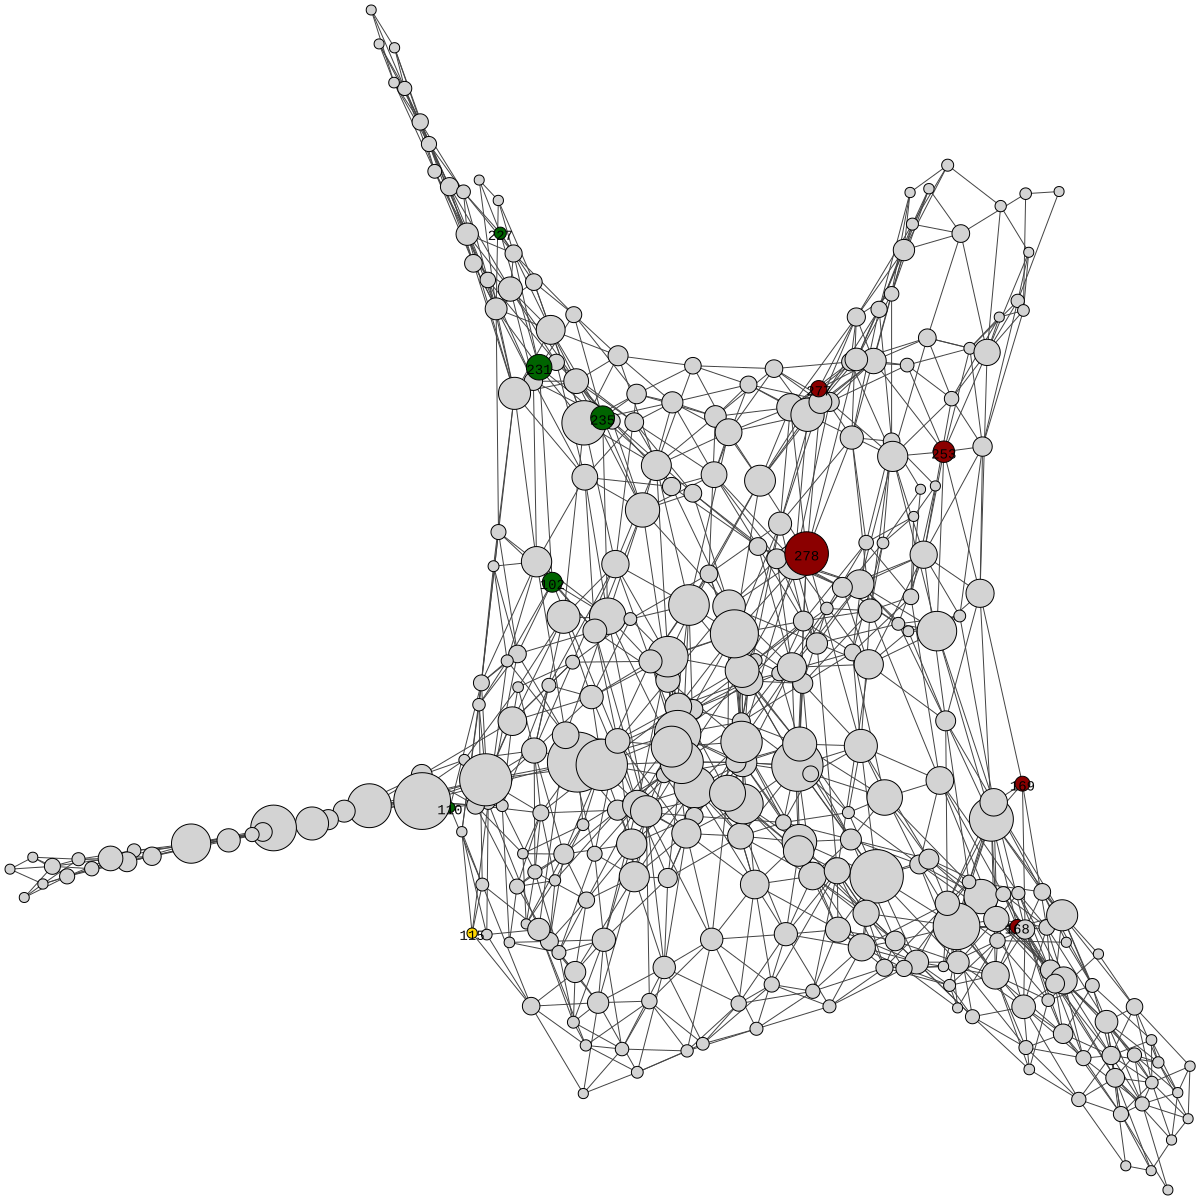

In [ ]:
# Creación de grafo de contacto y resaltar los aminoácidos de alta atención

## Grafo de contacto de proteínas ##

# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

# Configuración de secuencia y

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_info = []  # lista de tuplas: [(chain_id, resnum, icode), ...]

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:
                    coord = residue["CA"].get_coord()
                    resid = (chain.id, residue.id[1], residue.id[2].strip())  # ('A', 234, '')
                    CA_coord.append(coord)
                    CA_info.append(resid)

node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid: idx for idx, resid in enumerate(CA_info)}


# === Árbol de búsqueda y pares ===
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(CA_coord[i] - CA_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Grafo ===

g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# === Cálculo de caminos más cortos ===

shortest_paths = []
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]  # Lista de colores que se asignarán a los caminos

for a_resid in sitio_A:
    for o_resid in sitio_O:
        key_a = (chain_id, a_resid, "")
        key_o = (chain_id, o_resid, "")
        if key_a in resid_to_node and key_o in resid_to_node:
            a = resid_to_node[key_a]
            o = resid_to_node[key_o]
            try:
                path = g.get_shortest_paths(a, to=o)[0]
                if path:
                    shortest_paths.append({
                        "path": path,
                        "length": len(path),
                        "color": colors[len(shortest_paths) % len(colors)],
                        "nodes": (a_resid, o_resid),
                    })
            except:
                continue

# Calculamos el betweenness de los nodos

g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])

# Escalar tamaños
g.vs["size"] = [
    10 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.vs["color"] = ["lightgray"]
g.vs["label"] = [None] * len(g.vs)

user_input = input("Introduce el residuo en formato (cadena, número de residuo, código de inserción) (ejemplo: 'A', 234, ''): ")
user_resid = eval(user_input)  # Convertir el input a tupla
chain_id, resnum, icode = user_resid

key = (chain_id, resnum, icode)
if key in resid_to_node:
    node_idx = resid_to_node[key]
    centrality_score = g.vs[node_idx]["betweenness"]
    print(f"Centralidad de intermediación (betweenness) para el residuo {user_resid}: {centrality_score:.2f}")
else:
    print(f"El residuo {user_resid} no se encuentra en el grafo.")

# === Sitios de interés ===
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkred"
        label = resid
        g.vs[node_idx]["label"] = label

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkgreen"
        label = resid
        g.vs[node_idx]["label"] = label

for resid in user_resid:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "gold"
        label = resid
        g.vs[node_idx]["label"] = label

# === Plot ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1200, 1200), margin=10)